## Key Business Questions

#### Purpose: 

Analysis and Visualization of the data that provide key insights and help answer important business questions.


### Initialization, Data Frame loading, Tidying, Tests:

#### Loading:

In [1]:
from src.seanlib import *

In [19]:
#Lets load our data:
dfOR = pd.read_excel('./data/online_retail.xlsx')
dfOR['InvoiceNo'] = dfOR['InvoiceNo'].astype('str') #Need to get rid of refunds.
dfOR = dfOR[~dfOR['InvoiceNo'].str.contains('C')]  

In [25]:
dfOR.head()
dfOR.columns
dfOR.shape
dfOR.info()
#We need to change some data types here.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country'], dtype='object')

(532621, 8)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532621 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      532621 non-null object
StockCode      532621 non-null object
Description    531167 non-null object
Quantity       532621 non-null int64
InvoiceDate    532621 non-null datetime64[ns]
UnitPrice      532621 non-null float64
CustomerID     397924 non-null float64
Country        532621 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.6+ MB


#### Data Cleanup:

In [26]:
#First check for, and remove nulls. Some descriptions and customer ids are nulls. 
#We unfortunately lose about 25% of the data...for now.[***!]
dfOR.isnull().sum()
dfOR.dropna(inplace=True)
dfOR.shape

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134697
Country             0
dtype: int64

(397924, 8)

In [27]:
#Let us first rename the columns
dfOR.rename(columns=str.lower,inplace=True)

In [28]:
#Let us convert our numerical quantities to more suitable data types. Our numbers are reasonable
#in size, and don't require float64's

dfOR = dfOR.astype({'quantity': 'int32', 'unitprice':'float32','customerid':'int32'},copy=False)
dfOR.dtypes

invoiceno              object
stockcode              object
description            object
quantity                int32
invoicedate    datetime64[ns]
unitprice             float32
customerid              int32
country                object
dtype: object

In [8]:
dfOR["invoicedate"].iloc[1]

Timestamp('2010-12-01 08:26:00')

#### Basic Data Tests:

Guide: Blue lines indicate max/min value. Red Lines indicate cutoff of outliers.


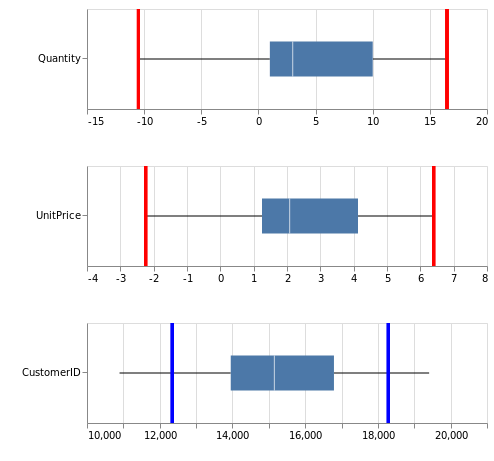

In [25]:
#What does our numerical data look like?
boxplotblast(dfOR)

In [26]:
#There are refunds, returns or negative transactions in our dataset.
[dfOR["UnitPrice"].min(),dfOR["UnitPrice"].max() ,dfOR["Quantity"].min(),dfOR["Quantity"].max()]

[-11062.06, 38970.0, -80995, 80995]

In [53]:
#Is there always 1 customer per invoice number?
#Idea: We can't use a unique() function for aggregation of GroupBy Dictionary objects.
#We can implement unique, by getting the max and min of each group (on customerid).
#If unique, they should be the same!
invGroupMin = dfOR.groupby(by="invoiceno").min()
invGroupMax = dfOR.groupby(by="invoiceno").max()
(invGroupMin["customerid"] == invGroupMax["customerid"]).value_counts()

#Answer: YES

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [90]:
dfOR["invoicedate"].iloc[1].day

1

In [91]:
dfOR["invoicedate"].tail().apply(lambda x: x)

541905    2011-12-09 12:50:00
541906    2011-12-09 12:50:00
541907    2011-12-09 12:50:00
541908    2011-12-09 12:50:00
mark                        1
Name: invoicedate, dtype: object

In [101]:
#Do we have any missing timeline data?
#Lets see the overall spacing of the dates, using a strip plot
#Fixing JSON date not serializable error:
#https://stackoverflow.com/questions/50404559/python-error-typeerror-object-of-type-timestamp-is-not-json-serializable
#We actually need strings for the JSON parser to work! Not python time objects!

holddates = dfOR["invoicedate"].astype("str",copy=True)
timeDF = pd.DataFrame({"mark":dfOR["invoicedate"].apply(lambda x: x.day),
                       "invoicedate":holddates })
timeDF.drop_duplicates(inplace=True)
timeDF.shape




(20460, 2)

In [100]:
hold = dfOR["invoicedate"].apply(lambda x: str(x.year) + "-" + str(x.month) + "-" + str(x.day))

hold.head(10)

0    2010-12-1
1    2010-12-1
2    2010-12-1
3    2010-12-1
4    2010-12-1
5    2010-12-1
6    2010-12-1
7    2010-12-1
8    2010-12-1
9    2010-12-1
Name: invoicedate, dtype: object

In [103]:
dfOR["invoicedate"].max()

Timestamp('2011-12-09 12:50:00')

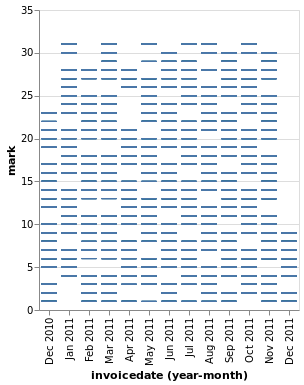

In [102]:
#So we see that 
stripChart = alt.Chart(timeDF).mark_tick().encode(
alt.X("yearmonth(invoicedate):O"),
alt.Y("mark:Q"))
stripChart

In [107]:
#Lets make another chart that represents time. We will use a heatmap in Altair

holddates = dfOR["invoicedate"].astype("str",copy=True)
timeDF = pd.DataFrame({"mark":dfOR["invoicedate"].apply(lambda x: x.day),
                       "invoicedate":holddates })

timeDF["invoicedate"] = dfOR["invoicedate"].apply(lambda x: str(x.year) + "-" + str(x.month) + "-" + str(x.day))

timeGroup = timeDF.groupby("invoicedate",as_index=False).count() #Should return a dataframe

timeGroup.shape



(305, 2)

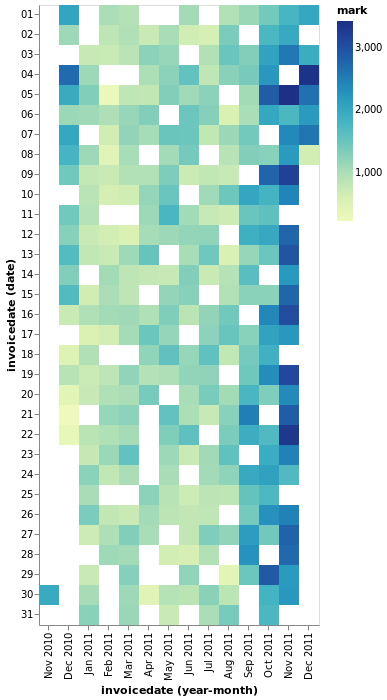

In [109]:
#This is a much more effective chart!
heatChart = alt.Chart(timeGroup).mark_rect().encode(
alt.X("yearmonth(invoicedate):O"),
alt.Y("date(invoicedate):O"),
alt.Color("mark"))

heatChart

### Plot Sales Trends

Sales per Year: / Quarter / Month / Week

With Altair's Time filtering function for encoded fields, this is quite easy!


In [124]:
#Support Code:
#Lets first extract a subDF:
#Assumption: We know InvoiceNum <-> CustomerID are 1 to 1. It is assumed that each Unique invoice also has a fixed
#date, not multiple dates!

#Avoid copying error that is thrown. First boil down our dataframe to what we need.
#Lets leave the TimeStamp Object as it is. And then convert to string for Altair later.
salesTrendDF = pd.DataFrame({"invoicedate":dfOR["invoicedate"],"itemcost":dfOR["unitprice"]*dfOR["quantity"]})
salesTrendDF.head()
salesTrendGroup = salesTrendDF.groupby(by="invoicedate",as_index=False).sum()


    


,invoicedate,itemcost
0,2010-12-01 08:26:00,15.300000
1,2010-12-01 08:26:00,20.340001
2,2010-12-01 08:26:00,22.000000
3,2010-12-01 08:26:00,20.340001
4,2010-12-01 08:26:00,20.340001


In [36]:
#Purpose: TimeStamp String -> String
#Signature: Get out the given period from the Timestamp using object properties.
def timeperiodstr(x,period):
    retVal = x
    if (period == "year"):
        retVal = str(x.year) 
    elif (period == "quarter"):
        retVal = str(x.year) + " " + "Q" + str(x.quarter)
    elif (period == "month"):
        retVal = str(x.year) + " " + str(x.month)
    elif (period == "week"):
        retVal = str(x.year) + " " + str(x.week)
    else:
        raise Exception("Invalid Time Period given: " + period)
    return retVal
    
#Signature: DataFrame, String -> Chart
#Purpose: Take our salesTrendGroup Dataframe, and aggregate it based on the time period given
def gen_salesbars(df, period):
    aggDF = pd.DataFrame({"invoicedate":df["invoicedate"],"itemcost":df["unitprice"]*df["quantity"]})
        
    #Here, we convert our invoicedate TimeStamp to time period strings
    aggDF["invoicedate"] = aggDF["invoicedate"].apply(timeperiodstr,args=(period,)) 
    aggDF = aggDF.groupby(by="invoicedate",as_index=False).sum()
    
    theChart = alt.Chart(aggDF,title="Sales Per " + str(period)).mark_bar().encode(
        alt.X("invoicedate:O"),alt.Y("itemcost"))
    
    return theChart

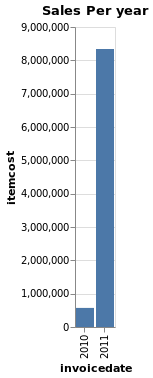

In [38]:
gen_salesbars(dfOR,"year")

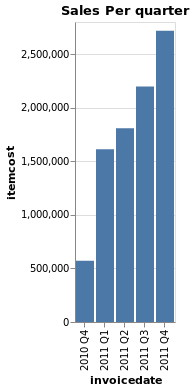

In [39]:
#Sales per Quarter:
gen_salesbars(dfOR,"quarter")

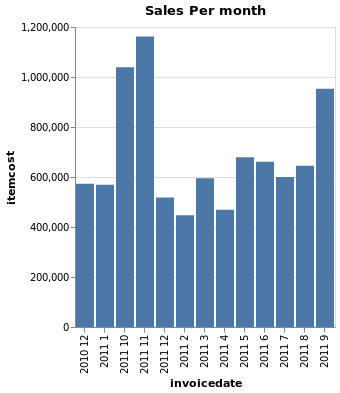

In [40]:
#Sales per Month:
#We have a string sorting error, 2011 11 and 12 are at the beginning of the chart!
gen_salesbars(dfOR,"month")

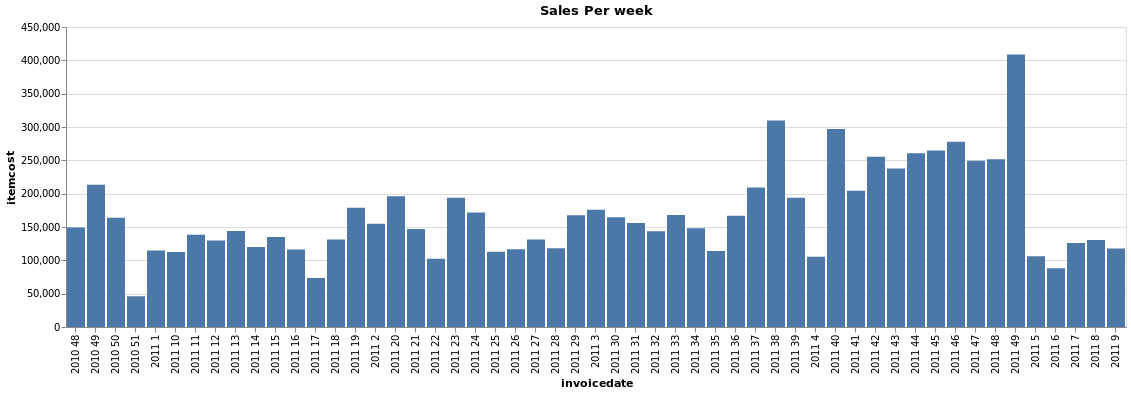

In [41]:
#Sales per Week:
gen_salesbars(dfOR,"week")

### Plot Products with the highest Sales by Money, Volume


### Country-Wise Analysis:

Plot sales by country. Visualize the best selling product for each Country.


### Basket Size:

*Average order value - What is the average $ amount per order?*

To answer this question, we need to groupby invoice number, calculate the total for each transaction (sum), and then aggregate again to get the average of all transactions.


In [20]:
groupDF = dfOR.head(20).groupby(by="InvoiceNo",axis=0)

for key,item in groupDF:
    print(key)
    print(item)
    break

groupDF.sum()

536365
  InvoiceNo StockCode                          Description  Quantity         InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00       2.55     17850.0  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00       2.75     17850.0  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2 2010-12-01 08:26:00       7.65     17850.0  United Kingdom
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6 2010-12-01 08:26:00       4.

,Quantity,UnitPrice,CustomerID
InvoiceNo,,,
536365,40,27.37,124950.0
536366,12,3.70,35700.0
536367,79,50.29,143517.0


### Customer Analysis:

Total Count of customers. Avg. Spend per customer. Avg Number of orders per customer. Distribution of customer spend. Distribution of customers by shopping frequency (number of customers that shop once, twice, three+ times).
